### Load experiment meta-data

In [55]:
from calibrate_ods.src.helpers.load_experiment_metadata import load_experiment_config

In [56]:
input_path = "/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/"

In [57]:
config, sim_setup = load_experiment_config(config=input_path + 'config.json',
                        sim_setup=input_path + 'simulation_setups.json',)

In [58]:
config

{'NETWORK': PosixPath('/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data'),
 'SUMO': PosixPath('/usr/local/opt/sumo/share/sumo')}

# Run simulations

Steps:
1. Create OD meta-files that for a given count, creates a random trajectoy of vehicles moving from O -> D
2. Run SUMO against the latter files
3. Parse output of simulation and yields the aggregated value of vehicles which arrive to a given node in th network



### Step 1. Create OD meta-data

In [62]:
import numpy as np
from calibrate_ods.src.helpers.generate_od_xml import generate_od_xml

prefix_run = 'iter'
#od_rand = np.random.rand(4)*200
od_rand = np.array([500,500,900,900])
#print(prefix_run, np.sum(od_rand))
    
generate_od_xml(od_rand, config, sim_setup, prefix_run)


printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml


### Step 2-3: Run SUMO and parse output

In [63]:
from calibrate_ods.src.simulator.run_sumo_and_parse_output import run_sumo_and_parse_output

df_simulated = run_sumo_and_parse_output(config, sim_setup, prefix_run)


### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (6ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4ms ~= 250.00*RT, ~164000.00UPS, vehicles TOT 2800 ACT 656 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulat

In [64]:
df_simulated

,EdgeID,interval_begin,interval_end,interval_nVehContrib,interval_harmonicMeanSpeed
0,#EdgeL5,54000.0,57600.0,319.666667,13.500000
1,#EdgeL7,54000.0,57600.0,414.333333,13.603333


### Obtain ground-truth

In [23]:
from calibrate_ods.src.simulator.ground_truth import run_ground_truth_and_parse
df_gt_data = run_ground_truth_and_parse(config, sim_setup)

od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.gt_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/gt_od_trips.trips.xml 
Success.
sumo --output-prefix gt_ --ignore-route-errors=true --net-file=/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml --routes=/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/gt_od_trips.trips.xml -b 54000 -e 57600 --additional-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml --duration-log.statistics --xml-validation never --vehroutes /Users/rodrse/Documents/DemandCalibration/notebooks

# Compute objective

In [24]:
from calibrate_ods.src.stats.nrmse_counts import compute_nrmse_counts

loss_estimate = compute_nrmse_counts(df_gt_data, df_simulated)
loss_estimate

0.956698024777138

### wrap objective x -> f(x)

In [25]:
def objective(x):
    
    prefix_run = 'iter'    
    generate_od_xml(x, config, sim_setup, prefix_run)
    df_simulated = run_sumo_and_parse_output(config, sim_setup, prefix_run)
    loss_estimate = compute_nrmse_counts(df_gt_data, df_simulated)
    df_output = pd.DataFrame(x.reshape(-1, len(x)),columns = ['x1','x2','x3','x4'])
    df_output['loss_estimate'] = loss_estimate
    
    return df_output

# Bayesian optimization

In [26]:
import os
import torch
import pandas as pd

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double


### Declare search space

In [27]:
# dimensionality of input space
d = 4 
bounds = torch.tensor([[400,400,800,800],[600,600,1000,1000]], device=device, dtype=dtype) 
bounds

tensor([[ 400.,  400.,  800.,  800.],
        [ 600.,  600., 1000., 1000.]], dtype=torch.float64)

### Generate batch of policies using Sobol sequences

In [28]:
from torch.quasirandom import SobolEngine
n0 = 25
dim = 4
sobol = SobolEngine(dim, scramble=True)
x_0 = sobol.draw(n0).to(dtype=dtype)

In [29]:
from botorch.utils.transforms import unnormalize
# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)


In [30]:
df_0 = [
    objective(x) for x in train_X0.cpu().detach().numpy()
]

df_0 = pd.concat(df_0)
df_0['iter'] = 0

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (6ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.


Step #57600.00 (6ms ~= 166.67*RT, ~132333.33UPS, vehicles TOT 2926 ACT 794 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 12.58s
 Real time factor: 286.26
 UPS: 143416.666667
Vehicles: 
 Inserted: 2926
 Running: 794
 Waiting: 0
 Teleports: 1 (Yield: 1)
Statistics (avg of 2132):
 RouteLength: 4357.88
 Speed: 10.90
 Duration: 514.10
 WaitingTime: 91.98
 TimeLoss: 198.53
 DepartDelay: 0.49

DijkstraRouter answered 2926 queries and explored 9.98 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
printing /Users/rodrse/Documents/DemandCalibration

Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (0ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4ms ~= 250.00*RT, ~175250.00UPS, vehicles TOT 2947 ACT 701 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 13.63s
 Real time factor: 264.181
 UPS: 126630.806487
Vehicles: 
 Inserted: 2947
 Running: 701
 Waiting: 0
Statistics (avg of 2246):
 RouteLength: 4414.42
 Speed: 11.80
 Duration: 442.11
 WaitingTime: 70.76
 TimeLoss: 122.24
 DepartDelay: 0.49

DijkstraRouter answered 2947 queries and explored 10.22 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/l

Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (11ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (3ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (6ms ~= 166.67*RT, ~126833.33UPS, vehicles TOT 2942 ACT 761 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 14.36s
 Real time factor: 250.731
 UPS: 132054.882296
Vehicles: 
 Inserted: 2942
 Running: 761
 Waiting: 0
Statistics (avg of 2181):
 RouteLength: 4404.60
 Speed: 10.62
 Duration: 523.89
 WaitingTime: 86.67
 TimeLoss: 204.16
 DepartDelay: 0.49

DijkstraRouter answered 2942 queries and explored 10.13 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/

Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (7ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4ms ~= 250.00*RT, ~140500.00UPS, vehicles TOT 2733 ACT 562 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 9.85s
 Real time factor: 365.594
 UPS: 144787.041739
Vehicles: 
 Inserted: 2733
 Running: 562
 Waiting: 0
Statistics (avg of 2171):
 RouteLength: 4416.57
 Speed: 12.13
 Duration: 421.54
 WaitingTime: 63.06
 TimeLoss: 101.29
 DepartDelay: 0.31

DijkstraRouter answered 2733 queries and explored 10.20 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/lo

Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (6ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5ms ~= 200.00*RT, ~137600.00UPS, vehicles TOT 2702 ACT 688 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 11.18s
 Real time factor: 322.119
 UPS: 142388.421618
Vehicles: 
 Inserted: 2702
 Running: 688
 Waiting: 0
Statistics (avg of 2014):
 RouteLength: 4370.68
 Speed: 10.84
 Duration: 518.47
 WaitingTime: 107.05
 TimeLoss: 201.53
 DepartDelay: 0.49

DijkstraRouter answered 2702 queries and explored 9.96 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/l

### GP model surrogate

In [31]:
import torch
import matplotlib.pyplot as plt

from botorch.models.transforms import Normalize, Standardize

from botorch.utils.transforms import normalize

from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_mll


train_X = torch.from_numpy(df_0[["x1","x2","x3","x4"]].values)
train_X_norm = normalize(train_X,bounds)

train_Y = -torch.from_numpy(df_0[["loss_estimate"]].values)


def initialize_gp_model(train_X,train_Y):
            
    gp_model = SingleTaskGP(
        train_X=train_X,
        train_Y=train_Y,
        outcome_transform=Standardize(m=1)
    )

    gp_mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    
    return gp_model, gp_mll


gp_model, gp_mll = initialize_gp_model(train_X_norm,train_Y)

# Fit model
fit_gpytorch_mll(gp_mll)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
  )
)

### Acquisition Function: q-EI

In [33]:
# Acquisition function
from botorch.acquisition import qExpectedImprovement
from botorch.sampling.stochastic_samplers import StochasticSampler

sampler = StochasticSampler(sample_shape=torch.Size([128]))
qEI = qExpectedImprovement(gp_model, best_f=max(train_Y), sampler=sampler)


In [35]:
from botorch.utils.transforms import unnormalize
from botorch.optim import optimize_acqf
    
def optimize_acqf_and_get_observation(acq_func,bounds):
    """Optimizes the acquisition function, and returns a new candidate."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.tensor([[0.0] * dim, [1.0] * dim], device=device, dtype=dtype),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )

    # observe new values 
    new_x = candidates.detach()
    
    return unnormalize(new_x, bounds)

In [36]:
BATCH_SIZE = 1 
NUM_RESTARTS = 5 
RAW_SAMPLES = 32 

new_x = optimize_acqf_and_get_observation(
    acq_func=qEI,
    bounds=bounds
)

new_x


tensor([[527.0356, 464.4139, 950.7920, 930.8108]], dtype=torch.float64)

### Run loop

In [37]:
NITER = 500
output = [df_0]
best_value = []

for i in range(NITER):
    
    print(f"####### {i+1} ########")
    
    df_ = df_0 if i == 0 else df_i
    
    n_obs = df_.shape[0]
    print(f"##### n={n_obs} #####")
    
    # Training data
    train_X = torch.from_numpy(df_[["x1","x2","x3","x4"]].values)    
    train_X_norm = normalize(train_X,bounds)
    
    train_Y = -torch.from_numpy(df_[["loss_estimate"]].values) # Take negative
    
    # best value so far
    best_y = train_Y.max()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")

    # Declare model with newest data
    gp_model, gp_mll = initialize_gp_model(train_X_norm,train_Y)

    # Fit model
    fit_gpytorch_mll(gp_mll)

    # Construct acquistion function 
    sampler = StochasticSampler(sample_shape=torch.Size([128]))
    qEI = qExpectedImprovement(gp_model, best_f=best_y, sampler=sampler)
    
    # Maximize acquisition function to get next observation
    new_x = optimize_acqf_and_get_observation(acq_func=qEI,bounds=bounds)
    
    # Query SUMO on new sampling location
    df_simulation = objective(new_x.cpu().detach().numpy().reshape(-1))
    df_simulation['iter'] = i+1
    
    # Update history of training data
    output.append(df_simulation)
    
    df_i = pd.concat(output)
    
    
    

####### 1 ########
##### n=25 #####
##### best_value=-0.6555992070126919 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading

Step #57600.00 (5ms ~= 200.00*RT, ~138000.00UPS, vehicles TOT 2942 ACT 690 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 13.32s
 Real time factor: 270.189
 UPS: 125031.672171
Vehicles: 
 Inserted: 2942
 Running: 690
 Waiting: 0
Statistics (avg of 2252):
 RouteLength: 4413.78
 Speed: 12.23
 Duration: 417.32
 WaitingTime: 59.14
 TimeLoss: 97.36
 DepartDelay: 0.40

DijkstraRouter answered 2942 queries and explored 10.39 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 6 ########
##### n=30 #####
##### best_value=-0.6487165909087482 #

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4

Step #57600.00 (5ms ~= 200.00*RT, ~101800.00UPS, vehicles TOT 2522 ACT 509 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 9.07s
 Real time factor: 397.088
 UPS: 141294.396647
Vehicles: 
 Inserted: 2522
 Running: 509
 Waiting: 0
Statistics (avg of 2013):
 RouteLength: 4438.25
 Speed: 12.32
 Duration: 426.40
 WaitingTime: 68.96
 TimeLoss: 103.43
 DepartDelay: 0.49

DijkstraRouter answered 2522 queries and explored 10.52 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 15 ########
##### n=39 #####
##### best_value=-0.646107163629262 #

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (6ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5

Step #57600.00 (7ms ~= 142.86*RT, ~122571.43UPS, vehicles TOT 2881 ACT 858 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 13.84s
 Real time factor: 260.191
 UPS: 139250.722752
Vehicles: 
 Inserted: 2881
 Running: 858
 Waiting: 0
Statistics (avg of 2023):
 RouteLength: 4329.85
 Speed: 10.64
 Duration: 572.84
 WaitingTime: 128.57
 TimeLoss: 259.15
 DepartDelay: 0.49

DijkstraRouter answered 2881 queries and explored 9.94 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 24 ########
##### n=48 #####
##### best_value=-0.6421053213730706

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (6ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (0ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (3

Step #57600.00 (8ms ~= 125.00*RT, ~91250.00UPS, vehicles TOT 2906 ACT 730 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 14.55s
 Real time factor: 247.355
 UPS: 120494.915487
Vehicles: 
 Inserted: 2906
 Running: 730
 Waiting: 0
Statistics (avg of 2176):
 RouteLength: 4342.78
 Speed: 10.88
 Duration: 520.20
 WaitingTime: 97.53
 TimeLoss: 205.93
 DepartDelay: 0.47

DijkstraRouter answered 2906 queries and explored 9.83 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 33 ########
##### n=57 #####
##### best_value=-0.6421053213730706 

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (0ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5

Step #57600.00 (5ms ~= 200.00*RT, ~132600.00UPS, vehicles TOT 2891 ACT 663 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 11.66s
 Real time factor: 308.721
 UPS: 140689.649258
Vehicles: 
 Inserted: 2891
 Running: 663
 Waiting: 0
Statistics (avg of 2228):
 RouteLength: 4377.38
 Speed: 12.07
 Duration: 429.36
 WaitingTime: 69.74
 TimeLoss: 111.85
 DepartDelay: 0.49

DijkstraRouter answered 2891 queries and explored 10.13 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 42 ########
##### n=66 #####
##### best_value=-0.6421053213730706

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4

Step #57600.00 (6ms ~= 166.67*RT, ~98833.33UPS, vehicles TOT 2735 ACT 593 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 11.61s
 Real time factor: 310.131
 UPS: 126823.311509
Vehicles: 
 Inserted: 2735
 Running: 593
 Waiting: 0
Statistics (avg of 2142):
 RouteLength: 4424.10
 Speed: 12.20
 Duration: 425.27
 WaitingTime: 66.36
 TimeLoss: 104.04
 DepartDelay: 0.30

DijkstraRouter answered 2735 queries and explored 10.33 edges on average.
DijkstraRouter spent 0.01s answering queries (0.01ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 51 ########
##### n=75 #####
##### best_value=-0.6421053213730706

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (7ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (6

Step #57600.00 (4ms ~= 250.00*RT, ~167250.00UPS, vehicles TOT 2862 ACT 669 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 10.59s
 Real time factor: 340.072
 UPS: 157432.835821
Vehicles: 
 Inserted: 2862
 Running: 669
 Waiting: 0
Statistics (avg of 2193):
 RouteLength: 4386.59
 Speed: 11.80
 Duration: 448.04
 WaitingTime: 78.76
 TimeLoss: 130.10
 DepartDelay: 0.49

DijkstraRouter answered 2862 queries and explored 10.12 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 60 ########
##### n=84 #####
##### best_value=-0.6421053213730706

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (0ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (3

Step #57600.00 (3ms ~= 333.33*RT, ~171333.33UPS, vehicles TOT 2714 ACT 514 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 7.85s
 Real time factor: 458.716
 UPS: 171991.462793
Vehicles: 
 Inserted: 2714
 Running: 514
 Waiting: 0
Statistics (avg of 2200):
 RouteLength: 4401.61
 Speed: 12.10
 Duration: 418.21
 WaitingTime: 61.54
 TimeLoss: 98.62
 DepartDelay: 0.49

DijkstraRouter answered 2714 queries and explored 10.00 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 69 ########
##### n=93 #####
##### best_value=-0.6421053213730706 #

####### 73 ########
##### n=97 #####
##### best_value=-0.6421053213730706 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loadin

Step #57600.00 (5ms ~= 200.00*RT, ~133600.00UPS, vehicles TOT 2881 ACT 668 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 10.70s
 Real time factor: 336.511
 UPS: 156109.927089
Vehicles: 
 Inserted: 2881
 Running: 668
 Waiting: 0
Statistics (avg of 2213):
 RouteLength: 4396.94
 Speed: 11.78
 Duration: 443.65
 WaitingTime: 75.46
 TimeLoss: 125.48
 DepartDelay: 0.49

DijkstraRouter answered 2881 queries and explored 10.12 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 78 ########
##### n=102 #####
##### best_value=-0.639701477169734

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (4ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (3

Step #57600.00 (5ms ~= 200.00*RT, ~174800.00UPS, vehicles TOT 3155 ACT 874 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 14.27s
 Real time factor: 252.207
 UPS: 149838.167297
Vehicles: 
 Inserted: 3155
 Running: 874
 Waiting: 0
 Teleports: 1 (Yield: 1)
Statistics (avg of 2281):
 RouteLength: 4360.66
 Speed: 10.46
 Duration: 561.24
 WaitingTime: 93.74
 TimeLoss: 245.07
 DepartDelay: 0.49

DijkstraRouter answered 3155 queries and explored 9.99 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 87 ########
##### n=111 #####
##### best_

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (9

Step #57600.00 (3ms ~= 333.33*RT, ~205000.00UPS, vehicles TOT 2804 ACT 615 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 16.94s
 Real time factor: 212.465
 UPS: 89470.609065
Vehicles: 
 Inserted: 2804
 Running: 615
 Waiting: 0
Statistics (avg of 2189):
 RouteLength: 4378.75
 Speed: 12.23
 Duration: 423.96
 WaitingTime: 69.06
 TimeLoss: 106.58
 DepartDelay: 0.49

DijkstraRouter answered 2804 queries and explored 10.18 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 96 ########
##### n=120 #####
##### best_value=-0.6397014771697344

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (3

Step #57600.00 (4ms ~= 250.00*RT, ~166500.00UPS, vehicles TOT 2789 ACT 666 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 10.71s
 Real time factor: 336.291
 UPS: 159496.964035
Vehicles: 
 Inserted: 2789
 Running: 666
 Waiting: 0
Statistics (avg of 2123):
 RouteLength: 4404.59
 Speed: 11.25
 Duration: 478.49
 WaitingTime: 85.25
 TimeLoss: 159.22
 DepartDelay: 0.50

DijkstraRouter answered 2789 queries and explored 10.10 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 105 ########
##### n=129 #####
##### best_value=-0.63970147716973

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (7

Step #57600.00 (3ms ~= 333.33*RT, ~177333.33UPS, vehicles TOT 2738 ACT 532 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 8.57s
 Real time factor: 420.021
 UPS: 162433.555011
Vehicles: 
 Inserted: 2738
 Running: 532
 Waiting: 0
Statistics (avg of 2206):
 RouteLength: 4416.64
 Speed: 11.83
 Duration: 433.15
 WaitingTime: 69.48
 TimeLoss: 112.44
 DepartDelay: 0.49

DijkstraRouter answered 2738 queries and explored 9.99 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 114 ########
##### n=138 #####
##### best_value=-0.6397014771697344

Step #57600.00 (6ms ~= 166.67*RT, ~140166.67UPS, vehicles TOT 2976 ACT 841 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 12.85s
 Real time factor: 280.112
 UPS: 146335.434174
Vehicles: 
 Inserted: 2976
 Running: 841
 Waiting: 0
 Teleports: 1 (Yield: 1)
Statistics (avg of 2135):
 RouteLength: 4342.52
 Speed: 10.94
 Duration: 528.08
 WaitingTime: 104.72
 TimeLoss: 213.58
 DepartDelay: 0.50

DijkstraRouter answered 2976 queries and explored 9.92 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 117 ########
##### n=141 #####
##### bes

Step #57600.00 (7ms ~= 142.86*RT, ~114857.14UPS, vehicles TOT 3031 ACT 804 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 13.63s
 Real time factor: 264.162
 UPS: 144645.289111
Vehicles: 
 Inserted: 3031
 Running: 804
 Waiting: 0
Statistics (avg of 2227):
 RouteLength: 4349.95
 Speed: 10.71
 Duration: 545.72
 WaitingTime: 99.37
 TimeLoss: 230.70
 DepartDelay: 0.49

DijkstraRouter answered 3031 queries and explored 9.92 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 121 ########
##### n=145 #####
##### best_value=-0.639701477169734

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4

Step #57600.00 (5ms ~= 200.00*RT, ~140600.00UPS, vehicles TOT 2906 ACT 703 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 11.81s
 Real time factor: 304.878
 UPS: 150750.084688
Vehicles: 
 Inserted: 2906
 Running: 703
 Waiting: 0
Statistics (avg of 2203):
 RouteLength: 4430.20
 Speed: 10.96
 Duration: 494.74
 WaitingTime: 83.60
 TimeLoss: 173.55
 DepartDelay: 0.48

DijkstraRouter answered 2906 queries and explored 10.20 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 130 ########
##### n=154 #####
##### best_value=-0.63970147716973

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (4ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5

Step #57600.00 (5ms ~= 200.00*RT, ~110400.00UPS, vehicles TOT 2737 ACT 552 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 9.18s
 Real time factor: 392.285
 UPS: 153199.411572
Vehicles: 
 Inserted: 2737
 Running: 552
 Waiting: 0
Statistics (avg of 2185):
 RouteLength: 4416.60
 Speed: 11.50
 Duration: 446.02
 WaitingTime: 71.52
 TimeLoss: 125.47
 DepartDelay: 0.49

DijkstraRouter answered 2737 queries and explored 10.00 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 139 ########
##### n=163 #####
##### best_value=-0.639701477169734

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (6ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5

Step #57600.00 (4ms ~= 250.00*RT, ~148500.00UPS, vehicles TOT 2714 ACT 594 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 11.19s
 Real time factor: 321.63
 UPS: 129547.485035
Vehicles: 
 Inserted: 2714
 Running: 594
 Waiting: 0
Statistics (avg of 2120):
 RouteLength: 4402.87
 Speed: 12.48
 Duration: 412.34
 WaitingTime: 60.75
 TimeLoss: 93.15
 DepartDelay: 0.50

DijkstraRouter answered 2714 queries and explored 10.41 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 148 ########
##### n=172 #####
##### best_value=-0.6397014771697344

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5

Step #57600.00 (5ms ~= 200.00*RT, ~117200.00UPS, vehicles TOT 2694 ACT 586 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 9.60s
 Real time factor: 374.922
 UPS: 148925.744637
Vehicles: 
 Inserted: 2694
 Running: 586
 Waiting: 0
Statistics (avg of 2108):
 RouteLength: 4426.80
 Speed: 12.36
 Duration: 418.24
 WaitingTime: 62.86
 TimeLoss: 96.73
 DepartDelay: 0.49

DijkstraRouter answered 2694 queries and explored 10.45 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 157 ########
##### n=181 #####
##### best_value=-0.6397014771697344

Step #57600.00 (7ms ~= 142.86*RT, ~128000.00UPS, vehicles TOT 3026 ACT 896 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 16.04s
 Real time factor: 224.481
 UPS: 132333.104695
Vehicles: 
 Inserted: 3026
 Running: 896
 Waiting: 0
 Teleports: 3 (Yield: 3)
Statistics (avg of 2130):
 RouteLength: 4336.78
 Speed: 10.51
 Duration: 588.24
 WaitingTime: 123.13
 TimeLoss: 273.31
 DepartDelay: 0.49

DijkstraRouter answered 3026 queries and explored 9.97 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 160 ########
##### n=184 #####
##### bes

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (0ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5

Step #57600.00 (7ms ~= 142.86*RT, ~119428.57UPS, vehicles TOT 3042 ACT 836 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 14.50s
 Real time factor: 248.207
 UPS: 136995.794264
Vehicles: 
 Inserted: 3042
 Running: 836
 Waiting: 0
 Teleports: 1 (Yield: 1)
Statistics (avg of 2206):
 RouteLength: 4348.38
 Speed: 10.55
 Duration: 551.93
 WaitingTime: 97.32
 TimeLoss: 236.20
 DepartDelay: 0.50

DijkstraRouter answered 3042 queries and explored 9.94 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 167 ########
##### n=191 #####
##### best

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (6ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.


Step #57600.00 (12ms ~= 83.33*RT, ~72583.33UPS, vehicles TOT 2949 ACT 871 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 14.84s
 Real time factor: 242.522
 UPS: 135862.031797
Vehicles: 
 Inserted: 2949
 Running: 871
 Waiting: 0
 Teleports: 1 (Yield: 1)
Statistics (avg of 2078):
 RouteLength: 4352.95
 Speed: 10.56
 Duration: 564.88
 WaitingTime: 101.00
 TimeLoss: 249.18
 DepartDelay: 0.49

DijkstraRouter answered 2949 queries and explored 10.04 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 172 ########
##### n=196 #####
##### be

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (0ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (6

Step #57600.00 (6ms ~= 166.67*RT, ~122000.00UPS, vehicles TOT 2933 ACT 732 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 12.74s
 Real time factor: 282.53
 UPS: 140497.253178
Vehicles: 
 Inserted: 2933
 Running: 732
 Waiting: 0
Statistics (avg of 2201):
 RouteLength: 4386.99
 Speed: 10.75
 Duration: 520.08
 WaitingTime: 92.29
 TimeLoss: 202.21
 DepartDelay: 0.50

DijkstraRouter answered 2933 queries and explored 10.02 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 181 ########
##### n=205 #####
##### best_value=-0.639701477169734

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5

Step #57600.00 (5ms ~= 200.00*RT, ~114600.00UPS, vehicles TOT 2757 ACT 573 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 12.00s
 Real time factor: 300.125
 UPS: 119465.027095
Vehicles: 
 Inserted: 2757
 Running: 573
 Waiting: 0
Statistics (avg of 2184):
 RouteLength: 4407.74
 Speed: 12.33
 Duration: 417.93
 WaitingTime: 62.82
 TimeLoss: 98.13
 DepartDelay: 0.49

DijkstraRouter answered 2757 queries and explored 10.36 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 190 ########
##### n=214 #####
##### best_value=-0.639701477169734

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5

Step #57600.00 (5ms ~= 200.00*RT, ~135000.00UPS, vehicles TOT 2848 ACT 675 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 11.85s
 Real time factor: 303.823
 UPS: 151671.449067
Vehicles: 
 Inserted: 2848
 Running: 675
 Waiting: 0
Statistics (avg of 2173):
 RouteLength: 4409.76
 Speed: 10.89
 Duration: 505.75
 WaitingTime: 91.51
 TimeLoss: 185.53
 DepartDelay: 0.50

DijkstraRouter answered 2848 queries and explored 10.11 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 199 ########
##### n=223 #####
##### best_value=-0.63970147716973

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5

Step #57600.00 (15ms ~= 66.67*RT, ~53133.33UPS, vehicles TOT 2959 ACT 797 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 15.96s
 Real time factor: 225.578
 UPS: 123714.455793
Vehicles: 
 Inserted: 2959
 Running: 797
 Waiting: 0
Statistics (avg of 2162):
 RouteLength: 4379.81
 Speed: 10.44
 Duration: 564.95
 WaitingTime: 99.64
 TimeLoss: 247.51
 DepartDelay: 0.49

DijkstraRouter answered 2959 queries and explored 10.06 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 208 ########
##### n=232 #####
##### best_value=-0.63970147716973

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4

Step #57600.00 (4ms ~= 250.00*RT, ~148000.00UPS, vehicles TOT 2750 ACT 592 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 9.78s
 Real time factor: 368.249
 UPS: 155928.396072
Vehicles: 
 Inserted: 2750
 Running: 592
 Waiting: 0
Statistics (avg of 2158):
 RouteLength: 4418.16
 Speed: 11.60
 Duration: 451.47
 WaitingTime: 76.64
 TimeLoss: 131.19
 DepartDelay: 0.49

DijkstraRouter answered 2750 queries and explored 10.13 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 217 ########
##### n=241 #####
##### best_value=-0.639701477169734

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (6ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (0ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (8

Step #57600.00 (8ms ~= 125.00*RT, ~83875.00UPS, vehicles TOT 2691 ACT 671 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 13.88s
 Real time factor: 259.31
 UPS: 112837.138947
Vehicles: 
 Inserted: 2691
 Running: 671
 Waiting: 0
Statistics (avg of 2020):
 RouteLength: 4398.01
 Speed: 10.89
 Duration: 504.86
 WaitingTime: 97.52
 TimeLoss: 185.98
 DepartDelay: 0.48

DijkstraRouter answered 2691 queries and explored 10.07 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 226 ########
##### n=250 #####
##### best_value=-0.639701477169734

Step #57600.00 (8ms ~= 125.00*RT, ~102875.00UPS, vehicles TOT 2956 ACT 823 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 13.72s
 Real time factor: 262.372
 UPS: 140689.891407
Vehicles: 
 Inserted: 2956
 Running: 823
 Waiting: 0
 Teleports: 1 (Yield: 1)
Statistics (avg of 2133):
 RouteLength: 4346.54
 Speed: 10.67
 Duration: 545.38
 WaitingTime: 98.70
 TimeLoss: 229.81
 DepartDelay: 0.47

DijkstraRouter answered 2956 queries and explored 9.96 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 229 ########
##### n=253 #####
##### best

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5

Step #57600.00 (6ms ~= 166.67*RT, ~105666.67UPS, vehicles TOT 2818 ACT 634 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 12.09s
 Real time factor: 297.693
 UPS: 125304.473662
Vehicles: 
 Inserted: 2818
 Running: 634
 Waiting: 0
Statistics (avg of 2184):
 RouteLength: 4383.23
 Speed: 11.34
 Duration: 459.53
 WaitingTime: 78.45
 TimeLoss: 141.89
 DepartDelay: 0.49

DijkstraRouter answered 2818 queries and explored 9.94 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 238 ########
##### n=262 #####
##### best_value=-0.639701477169734

Step #57600.00 (9ms ~= 111.11*RT, ~97333.33UPS, vehicles TOT 2898 ACT 876 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 14.83s
 Real time factor: 242.751
 UPS: 133008.226568
Vehicles: 
 Inserted: 2898
 Running: 876
 Waiting: 0
 Teleports: 2 (Yield: 2)
Statistics (avg of 2022):
 RouteLength: 4340.80
 Speed: 10.63
 Duration: 567.00
 WaitingTime: 113.29
 TimeLoss: 252.40
 DepartDelay: 0.49

DijkstraRouter answered 2898 queries and explored 10.01 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 240 ########
##### n=264 #####
##### be

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (2ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (6

Step #57600.00 (6ms ~= 166.67*RT, ~117000.00UPS, vehicles TOT 2957 ACT 702 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 11.95s
 Real time factor: 301.356
 UPS: 151466.432279
Vehicles: 
 Inserted: 2957
 Running: 702
 Waiting: 0
Statistics (avg of 2255):
 RouteLength: 4425.91
 Speed: 11.11
 Duration: 480.33
 WaitingTime: 77.71
 TimeLoss: 159.73
 DepartDelay: 0.49

DijkstraRouter answered 2957 queries and explored 10.19 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 249 ########
##### n=273 #####
##### best_value=-0.63970147716973

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5

Step #57600.00 (4ms ~= 250.00*RT, ~143750.00UPS, vehicles TOT 2640 ACT 575 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 8.50s
 Real time factor: 423.38
 UPS: 159925.908503
Vehicles: 
 Inserted: 2640
 Running: 575
 Waiting: 0
Statistics (avg of 2065):
 RouteLength: 4363.36
 Speed: 11.67
 Duration: 449.08
 WaitingTime: 82.12
 TimeLoss: 132.67
 DepartDelay: 0.49

DijkstraRouter answered 2640 queries and explored 9.85 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 258 ########
##### n=282 #####
##### best_value=-0.6397014771697344 

Step #57600.00 (7ms ~= 142.86*RT, ~128285.71UPS, vehicles TOT 3013 ACT 898 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 14.61s
 Real time factor: 246.474
 UPS: 139652.471587
Vehicles: 
 Inserted: 3013
 Running: 898
 Waiting: 0
 Teleports: 1 (Yield: 1)
Statistics (avg of 2115):
 RouteLength: 4335.51
 Speed: 10.87
 Duration: 549.08
 WaitingTime: 102.16
 TimeLoss: 235.19
 DepartDelay: 0.49

DijkstraRouter answered 3013 queries and explored 9.98 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 260 ########
##### n=284 #####
##### bes

####### 264 ########
##### n=288 #####
##### best_value=-0.6397014771697344 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (7ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Load

Step #57600.00 (6ms ~= 166.67*RT, ~99166.67UPS, vehicles TOT 2822 ACT 595 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 9.80s
 Real time factor: 367.272
 UPS: 152704.550092
Vehicles: 
 Inserted: 2822
 Running: 595
 Waiting: 0
Statistics (avg of 2227):
 RouteLength: 4422.05
 Speed: 12.25
 Duration: 415.21
 WaitingTime: 59.39
 TimeLoss: 94.72
 DepartDelay: 0.49

DijkstraRouter answered 2822 queries and explored 10.34 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 269 ########
##### n=293 #####
##### best_value=-0.6397014771697344

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (6ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5

Step #57600.00 (5ms ~= 200.00*RT, ~130800.00UPS, vehicles TOT 2914 ACT 654 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 13.09s
 Real time factor: 275.061
 UPS: 119900.672372
Vehicles: 
 Inserted: 2914
 Running: 654
 Waiting: 0
Statistics (avg of 2260):
 RouteLength: 4383.80
 Speed: 12.37
 Duration: 407.44
 WaitingTime: 56.27
 TimeLoss: 89.74
 DepartDelay: 0.49

DijkstraRouter answered 2914 queries and explored 10.22 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 278 ########
##### n=302 #####
##### best_value=-0.639701477169734

Step #57600.00 (8ms ~= 125.00*RT, ~107875.00UPS, vehicles TOT 3027 ACT 863 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 18.19s
 Real time factor: 197.889
 UPS: 111248.790677
Vehicles: 
 Inserted: 3027
 Running: 863
 Waiting: 0
 Teleports: 1 (Yield: 1)
Statistics (avg of 2164):
 RouteLength: 4357.53
 Speed: 10.54
 Duration: 553.40
 WaitingTime: 94.63
 TimeLoss: 237.64
 DepartDelay: 0.49

DijkstraRouter answered 3027 queries and explored 10.01 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 282 ########
##### n=306 #####
##### bes

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (6ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (0ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (8

python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 287 ########
##### n=311 #####
##### best_value=-0.6397014771697344 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (6ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (0ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (6

Step #57600.00 (7ms ~= 142.86*RT, ~118285.71UPS, vehicles TOT 2875 ACT 828 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 14.94s
 Real time factor: 240.98
 UPS: 127214.271370
Vehicles: 
 Inserted: 2875
 Running: 828
 Waiting: 0
 Teleports: 1 (Yield: 1)
Statistics (avg of 2047):
 RouteLength: 4362.70
 Speed: 10.60
 Duration: 557.60
 WaitingTime: 105.55
 TimeLoss: 241.74
 DepartDelay: 0.47

DijkstraRouter answered 2875 queries and explored 10.06 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 294 ########
##### n=318 #####
##### bes

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (0ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (6

Step #57600.00 (7ms ~= 142.86*RT, ~92142.86UPS, vehicles TOT 2762 ACT 645 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 12.79s
 Real time factor: 281.448
 UPS: 122406.770385
Vehicles: 
 Inserted: 2762
 Running: 645
 Waiting: 0
Statistics (avg of 2117):
 RouteLength: 4377.67
 Speed: 11.07
 Duration: 494.64
 WaitingTime: 96.16
 TimeLoss: 177.06
 DepartDelay: 0.49

DijkstraRouter answered 2762 queries and explored 9.98 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 303 ########
##### n=327 #####
##### best_value=-0.639701477169734

####### 307 ########
##### n=331 #####
##### best_value=-0.6397014771697344 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (6ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Load

Step #57600.00 (6ms ~= 166.67*RT, ~113000.00UPS, vehicles TOT 2889 ACT 678 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 12.72s
 Real time factor: 283.086
 UPS: 135900.290949
Vehicles: 
 Inserted: 2889
 Running: 678
 Waiting: 0
Statistics (avg of 2211):
 RouteLength: 4356.98
 Speed: 10.86
 Duration: 513.23
 WaitingTime: 97.47
 TimeLoss: 196.99
 DepartDelay: 0.49

DijkstraRouter answered 2889 queries and explored 9.82 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 312 ########
##### n=336 #####
##### best_value=-0.639701477169734

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4

Step #57600.00 (6ms ~= 166.67*RT, ~118333.33UPS, vehicles TOT 2892 ACT 710 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 10.84s
 Real time factor: 332.165
 UPS: 153185.643108
Vehicles: 
 Inserted: 2892
 Running: 710
 Waiting: 0
Statistics (avg of 2182):
 RouteLength: 4362.26
 Speed: 10.96
 Duration: 505.57
 WaitingTime: 96.22
 TimeLoss: 189.80
 DepartDelay: 0.49

DijkstraRouter answered 2892 queries and explored 9.91 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 321 ########
##### n=345 #####
##### best_value=-0.639701477169734

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4

Step #57600.00 (4ms ~= 250.00*RT, ~152500.00UPS, vehicles TOT 2863 ACT 610 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 10.55s
 Real time factor: 341.168
 UPS: 148577.047005
Vehicles: 
 Inserted: 2863
 Running: 610
 Waiting: 0
Statistics (avg of 2253):
 RouteLength: 4414.89
 Speed: 11.79
 Duration: 435.95
 WaitingTime: 67.53
 TimeLoss: 116.15
 DepartDelay: 0.49

DijkstraRouter answered 2863 queries and explored 10.13 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 330 ########
##### n=354 #####
##### best_value=-0.63970147716973

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5

Step #57600.00 (4ms ~= 250.00*RT, ~143500.00UPS, vehicles TOT 2635 ACT 574 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 10.42s
 Real time factor: 345.589
 UPS: 133758.183738
Vehicles: 
 Inserted: 2635
 Running: 574
 Waiting: 0
Statistics (avg of 2061):
 RouteLength: 4439.99
 Speed: 12.50
 Duration: 411.30
 WaitingTime: 58.09
 TimeLoss: 89.07
 DepartDelay: 0.49

DijkstraRouter answered 2635 queries and explored 10.71 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 339 ########
##### n=363 #####
##### best_value=-0.639701477169734

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (6ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (0ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5

Step #57600.00 (4ms ~= 250.00*RT, ~156750.00UPS, vehicles TOT 2768 ACT 627 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 9.55s
 Real time factor: 376.963
 UPS: 156388.167539
Vehicles: 
 Inserted: 2768
 Running: 627
 Waiting: 0
Statistics (avg of 2141):
 RouteLength: 4405.84
 Speed: 12.55
 Duration: 406.69
 WaitingTime: 56.66
 TimeLoss: 87.23
 DepartDelay: 0.49

DijkstraRouter answered 2768 queries and explored 10.61 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 348 ########
##### n=372 #####
##### best_value=-0.6397014771697344

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (4ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (6

Step #57600.00 (7ms ~= 142.86*RT, ~115000.00UPS, vehicles TOT 2788 ACT 805 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 12.54s
 Real time factor: 287.173
 UPS: 146187.779196
Vehicles: 
 Inserted: 2788
 Running: 805
 Waiting: 0
Statistics (avg of 1983):
 RouteLength: 4341.51
 Speed: 10.58
 Duration: 586.45
 WaitingTime: 136.80
 TimeLoss: 271.66
 DepartDelay: 0.49

DijkstraRouter answered 2788 queries and explored 9.96 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 357 ########
##### n=381 #####
##### best_value=-0.63970147716973

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4

Step #57600.00 (5ms ~= 200.00*RT, ~138600.00UPS, vehicles TOT 2747 ACT 693 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 10.60s
 Real time factor: 339.623
 UPS: 154787.641509
Vehicles: 
 Inserted: 2747
 Running: 693
 Waiting: 0
Statistics (avg of 2054):
 RouteLength: 4396.61
 Speed: 10.92
 Duration: 510.40
 WaitingTime: 95.95
 TimeLoss: 191.82
 DepartDelay: 0.49

DijkstraRouter answered 2747 queries and explored 10.12 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 366 ########
##### n=390 #####
##### best_value=-0.63970147716973

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (6ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4

Step #57600.00 (5ms ~= 200.00*RT, ~129800.00UPS, vehicles TOT 2853 ACT 649 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 10.59s
 Real time factor: 339.943
 UPS: 155989.518414
Vehicles: 
 Inserted: 2853
 Running: 649
 Waiting: 0
Statistics (avg of 2204):
 RouteLength: 4374.33
 Speed: 11.04
 Duration: 490.02
 WaitingTime: 88.49
 TimeLoss: 172.73
 DepartDelay: 0.49

DijkstraRouter answered 2853 queries and explored 9.90 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 375 ########
##### n=399 #####
##### best_value=-0.639701477169734

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5

Step #57600.00 (4ms ~= 250.00*RT, ~144250.00UPS, vehicles TOT 2785 ACT 577 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 9.57s
 Real time factor: 376.254
 UPS: 154653.114548
Vehicles: 
 Inserted: 2785
 Running: 577
 Waiting: 0
Statistics (avg of 2208):
 RouteLength: 4428.80
 Speed: 11.96
 Duration: 436.07
 WaitingTime: 71.83
 TimeLoss: 114.79
 DepartDelay: 0.50

DijkstraRouter answered 2785 queries and explored 10.21 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 384 ########
##### n=408 #####
##### best_value=-0.639701477169734

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4

Step #57600.00 (6ms ~= 166.67*RT, ~104833.33UPS, vehicles TOT 2776 ACT 629 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 8.68s
 Real time factor: 414.89
 UPS: 172905.497292
Vehicles: 
 Inserted: 2776
 Running: 629
 Waiting: 0
Statistics (avg of 2147):
 RouteLength: 4403.33
 Speed: 12.61
 Duration: 403.84
 WaitingTime: 55.79
 TimeLoss: 84.46
 DepartDelay: 0.50

DijkstraRouter answered 2776 queries and explored 10.61 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 393 ########
##### n=417 #####
##### best_value=-0.6397014771697344 

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4

Step #57600.00 (4ms ~= 250.00*RT, ~172250.00UPS, vehicles TOT 2813 ACT 689 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 10.50s
 Real time factor: 342.955
 UPS: 159855.577784
Vehicles: 
 Inserted: 2813
 Running: 689
 Waiting: 0
Statistics (avg of 2124):
 RouteLength: 4389.95
 Speed: 11.00
 Duration: 500.03
 WaitingTime: 93.00
 TimeLoss: 181.45
 DepartDelay: 0.50

DijkstraRouter answered 2813 queries and explored 10.03 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 402 ########
##### n=426 #####
##### best_value=-0.63970147716973

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4

Step #57600.00 (3ms ~= 333.33*RT, ~161666.67UPS, vehicles TOT 2493 ACT 485 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 6.94s
 Real time factor: 518.882
 UPS: 176393.629288
Vehicles: 
 Inserted: 2493
 Running: 485
 Waiting: 0
Statistics (avg of 2008):
 RouteLength: 4430.47
 Speed: 12.36
 Duration: 417.50
 WaitingTime: 62.63
 TimeLoss: 95.88
 DepartDelay: 0.49

DijkstraRouter answered 2493 queries and explored 10.44 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 411 ########
##### n=435 #####
##### best_value=-0.6397014771697344

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (0ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5

Step #57600.00 (4ms ~= 250.00*RT, ~163500.00UPS, vehicles TOT 2806 ACT 654 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 9.20s
 Real time factor: 391.389
 UPS: 172145.683844
Vehicles: 
 Inserted: 2806
 Running: 654
 Waiting: 0
Statistics (avg of 2152):
 RouteLength: 4395.46
 Speed: 12.10
 Duration: 423.24
 WaitingTime: 63.19
 TimeLoss: 104.33
 DepartDelay: 0.50

DijkstraRouter answered 2806 queries and explored 10.23 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 420 ########
##### n=444 #####
##### best_value=-0.639701477169734

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4

Step #57600.00 (4ms ~= 250.00*RT, ~172250.00UPS, vehicles TOT 2889 ACT 689 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 9.70s
 Real time factor: 371.134
 UPS: 176034.948454
Vehicles: 
 Inserted: 2889
 Running: 689
 Waiting: 0
Statistics (avg of 2200):
 RouteLength: 4363.77
 Speed: 11.04
 Duration: 492.06
 WaitingTime: 88.28
 TimeLoss: 175.83
 DepartDelay: 0.49

DijkstraRouter answered 2889 queries and explored 9.88 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 429 ########
##### n=453 #####
##### best_value=-0.6397014771697344

Step #57600.00 (5ms ~= 200.00*RT, ~171800.00UPS, vehicles TOT 3001 ACT 859 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 11.53s
 Real time factor: 312.256
 UPS: 175056.899991
Vehicles: 
 Inserted: 3001
 Running: 859
 Waiting: 0
 Teleports: 1 (Yield: 1)
Statistics (avg of 2142):
 RouteLength: 4333.98
 Speed: 10.72
 Duration: 558.24
 WaitingTime: 102.34
 TimeLoss: 244.03
 DepartDelay: 0.50

DijkstraRouter answered 3001 queries and explored 9.94 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 431 ########
##### n=455 #####
##### bes

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (4ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4

Step #57600.00 (3ms ~= 333.33*RT, ~196333.33UPS, vehicles TOT 2775 ACT 589 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 8.38s
 Real time factor: 429.697
 UPS: 176344.951062
Vehicles: 
 Inserted: 2775
 Running: 589
 Waiting: 0
Statistics (avg of 2186):
 RouteLength: 4411.41
 Speed: 12.05
 Duration: 425.99
 WaitingTime: 66.10
 TimeLoss: 106.07
 DepartDelay: 0.50

DijkstraRouter answered 2775 queries and explored 10.17 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 440 ########
##### n=464 #####
##### best_value=-0.639701477169734

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (0ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4

Step #57600.00 (4ms ~= 250.00*RT, ~169250.00UPS, vehicles TOT 2809 ACT 677 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 10.16s
 Real time factor: 354.47
 UPS: 165556.518314
Vehicles: 
 Inserted: 2809
 Running: 677
 Waiting: 0
Statistics (avg of 2132):
 RouteLength: 4406.15
 Speed: 10.89
 Duration: 503.64
 WaitingTime: 87.81
 TimeLoss: 184.13
 DepartDelay: 0.49

DijkstraRouter answered 2809 queries and explored 10.11 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 449 ########
##### n=473 #####
##### best_value=-0.639701477169734

Step #57600.00 (4ms ~= 250.00*RT, ~146750.00UPS, vehicles TOT 2769 ACT 587 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 8.22s
 Real time factor: 437.956
 UPS: 178485.279805
Vehicles: 
 Inserted: 2769
 Running: 587
 Waiting: 0
Statistics (avg of 2182):
 RouteLength: 4404.50
 Speed: 12.14
 Duration: 418.92
 WaitingTime: 62.52
 TimeLoss: 99.42
 DepartDelay: 0.49

DijkstraRouter answered 2769 queries and explored 10.05 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 451 ########
##### n=475 #####
##### best_value=-0.6397014771697344

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4

Step #57600.00 (4ms ~= 250.00*RT, ~144250.00UPS, vehicles TOT 2633 ACT 577 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 8.56s
 Real time factor: 420.561
 UPS: 165101.869159
Vehicles: 
 Inserted: 2633
 Running: 577
 Waiting: 0
Statistics (avg of 2056):
 RouteLength: 4431.91
 Speed: 12.36
 Duration: 417.79
 WaitingTime: 62.15
 TimeLoss: 95.86
 DepartDelay: 0.49

DijkstraRouter answered 2633 queries and explored 10.50 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 460 ########
##### n=484 #####
##### best_value=-0.6397014771697344

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (4ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (3

Step #57600.00 (4ms ~= 250.00*RT, ~157250.00UPS, vehicles TOT 2783 ACT 629 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 8.66s
 Real time factor: 415.56
 UPS: 179179.499019
Vehicles: 
 Inserted: 2783
 Running: 629
 Waiting: 0
Statistics (avg of 2154):
 RouteLength: 4442.89
 Speed: 12.19
 Duration: 421.75
 WaitingTime: 62.28
 TimeLoss: 99.18
 DepartDelay: 0.50

DijkstraRouter answered 2783 queries and explored 10.40 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 469 ########
##### n=493 #####
##### best_value=-0.6397014771697344 

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (0ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4

Step #57600.00 (5ms ~= 200.00*RT, ~158000.00UPS, vehicles TOT 2877 ACT 790 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 10.12s
 Real time factor: 355.802
 UPS: 178494.465309
Vehicles: 
 Inserted: 2877
 Running: 790
 Waiting: 0
Statistics (avg of 2087):
 RouteLength: 4352.35
 Speed: 10.83
 Duration: 529.84
 WaitingTime: 105.09
 TimeLoss: 215.09
 DepartDelay: 0.49

DijkstraRouter answered 2877 queries and explored 9.96 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 478 ########
##### n=502 #####
##### best_value=-0.63970147716973

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (4ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (3

Step #57600.00 (3ms ~= 333.33*RT, ~197666.67UPS, vehicles TOT 2743 ACT 593 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 8.29s
 Real time factor: 434.52
 UPS: 175083.162342
Vehicles: 
 Inserted: 2743
 Running: 593
 Waiting: 0
Statistics (avg of 2150):
 RouteLength: 4434.48
 Speed: 12.47
 Duration: 415.87
 WaitingTime: 61.79
 TimeLoss: 94.26
 DepartDelay: 0.49

DijkstraRouter answered 2743 queries and explored 10.61 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 487 ########
##### n=511 #####
##### best_value=-0.6397014771697344 

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (4

Step #57600.00 (5ms ~= 200.00*RT, ~146000.00UPS, vehicles TOT 2920 ACT 730 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 10.44s
 Real time factor: 344.795
 UPS: 173614.117422
Vehicles: 
 Inserted: 2920
 Running: 730
 Waiting: 0
Statistics (avg of 2190):
 RouteLength: 4357.74
 Speed: 10.88
 Duration: 514.79
 WaitingTime: 92.28
 TimeLoss: 198.93
 DepartDelay: 0.49

DijkstraRouter answered 2920 queries and explored 9.91 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
python /usr/local/opt/sumo/share/sumo/tools/xml/xml2csv.py /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_out.xml --x /usr/local/opt/sumo/share/sumo/data/xsd/det_e1_file.xsd -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/loopOutputs.csv
####### 496 ########
##### n=520 #####
##### best_value=-0.639701477169734

####### 500 ########
##### n=524 #####
##### best_value=-0.6397014771697344 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (5ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (0ms).
Load

In [38]:
df = pd.concat(output)

In [40]:
df_plot = df.query('iter>0')

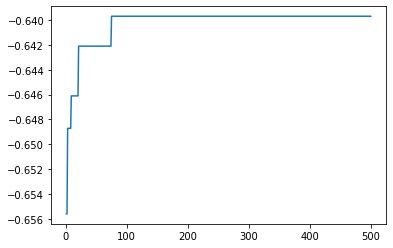

In [48]:
import numpy as np
import matplotlib.pyplot as plt

x = df_plot['iter']
y = df_plot['loss_estimate']

plt.plot(x, best_value)
#plt.legend(title='Parameter where:')
plt.show()

In [54]:
df.to_csv('./output/bo_500_iter_batchSize_1.csv',index = None)